<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/my_code%2C_varying_num_chans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [16]:
# use GPU if available

# device = 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import and inspect the data

In [17]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [18]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [19]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [20]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

### 
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

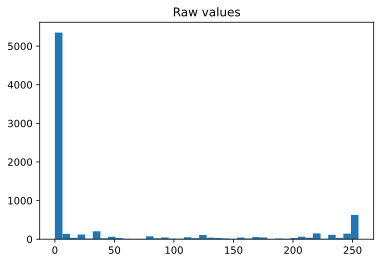

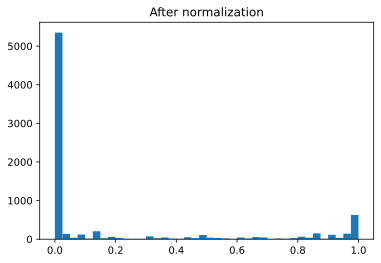

In [21]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('Raw values')
plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

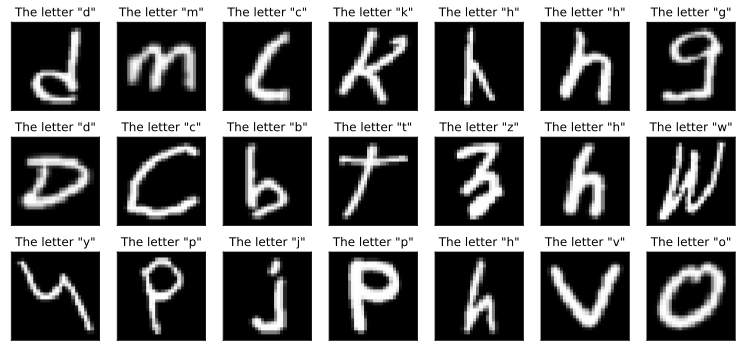

In [22]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])
  
  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]
  
  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [23]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [24]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [25]:
# create a class for the model
def makeTheNet(chans=(2,2)):

  class emnistnet(nn.Module):
    def __init__(self):
      super().__init__()

      
      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,chans[0],3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(chans[0]) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(chans[0],chans[1],3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(chans[1]) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*chans[1],50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))


      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))


      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)


      return x

  # create the model instance
  net = emnistnet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [26]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(chans=(2,2))

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2803, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [27]:
# a function that trains the model

def function2trainTheModel(chs):

  # number of epochs
  numepochs = 5
  
  # create a new model
  net,lossfun,optimizer = makeTheNet(chans=chs)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [28]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
numchans=(2,5,8)

trainMat = torch.zeros((len(numchans),len(numchans)))
testMat = trainRes

for idx, i in enumerate(numchans):
  for idy, j in enumerate(numchans):
    trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel((i,j))
    trainMat[idy,idx] = trainErr[-1]
    testMat[idy,idx] = testErr[-1]

In [29]:
trainMat

tensor([[13.0110, 11.4815, 10.6891],
        [10.1718,  8.8408,  8.2906],
        [ 8.2906,  7.4510,  7.1991]])

In [43]:
(np.meshgrid(numchans,numchans)[1]+np.meshgrid(numchans,numchans)[0]).flatten()

array([ 4,  7, 10,  7, 10, 13, 10, 13, 16])

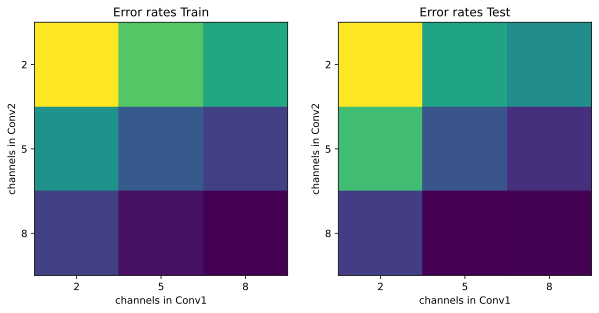

In [36]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(trainMat)
ax[0].set_xlabel('channels in Conv1')
ax[0].set_ylabel('channels in Conv2')
ax[0].set_title('Error rates Train')
ax[0].set_xticks(range(3))
ax[0].set_xticklabels(numchans)
ax[0].set_yticks(range(3))
ax[0].set_yticklabels(numchans)
# ax[0].colorbar()

ax[1].imshow(testMat)
ax[1].set_xlabel('channels in Conv1')
ax[1].set_ylabel('channels in Conv2')
ax[1].set_title('Error rates Test')
ax[1].set_xticks(range(3))
ax[1].set_xticklabels(numchans)
ax[1].set_yticks(range(3))
ax[1].set_yticklabels(numchans)

plt.show()

In [44]:
convnums = (np.meshgrid(numchans,numchans)[1]+np.meshgrid(numchans,numchans)[0]).flatten()
convnums

array([ 4,  7, 10,  7, 10, 13, 10, 13, 16])

In [45]:
trainMat.flatten()

tensor([13.0110, 11.4815, 10.6891, 10.1718,  8.8408,  8.2906,  8.2906,  7.4510,
         7.1991])

In [47]:
np.arange(4,17,2)

array([ 4,  6,  8, 10, 12, 14, 16])

Text(0, 0.5, 'True number')

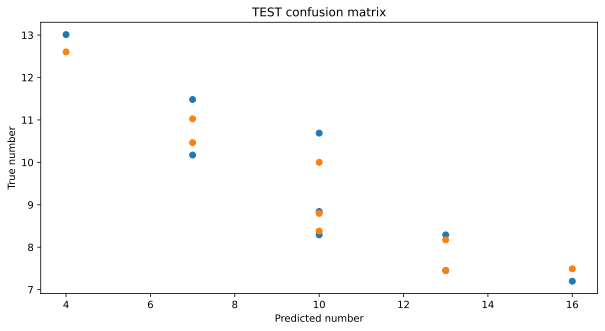

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(convnums,trainMat.flatten())
plt.scatter(convnums,testMat.flatten())
plt.xticks(np.arange(4,17,2))
# plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')